In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#!cp  '/content/gdrive/My Drive/Thesis/Datasets/RAVDESS.zip' '/content/gdrive/My Drive/Thesis/Datasets/RAVDESS.zip'
!unzip  '/content/gdrive/My Drive/thesis/Thesis/Datasets/CREMA-D.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/AudioWAV/1031_DFA_DIS_XX.wav  
  inflating: /content/AudioWAV/1031_DFA_FEA_XX.wav  
  inflating: /content/AudioWAV/1031_DFA_HAP_XX.wav  
  inflating: /content/AudioWAV/1031_DFA_NEU_XX.wav  
  inflating: /content/AudioWAV/1031_DFA_SAD_XX.wav  
  inflating: /content/AudioWAV/1031_IEO_ANG_HI.wav  
  inflating: /content/AudioWAV/1031_IEO_ANG_LO.wav  
  inflating: /content/AudioWAV/1031_IEO_ANG_MD.wav  
  inflating: /content/AudioWAV/1031_IEO_DIS_HI.wav  
  inflating: /content/AudioWAV/1031_IEO_DIS_LO.wav  
  inflating: /content/AudioWAV/1031_IEO_DIS_MD.wav  
  inflating: /content/AudioWAV/1031_IEO_FEA_HI.wav  
  inflating: /content/AudioWAV/1031_IEO_FEA_LO.wav  
  inflating: /content/AudioWAV/1031_IEO_FEA_MD.wav  
  inflating: /content/AudioWAV/1031_IEO_HAP_HI.wav  
  inflating: /content/AudioWAV/1031_IEO_HAP_LO.wav  
  inflating: /content/AudioWAV/1031_IEO_HAP_MD.wav  
  inflating: /content/AudioWAV/1031_IEO_NEU_XX.w

In [ ]:
sample_rate = 48000

In [ ]:
def feature_melspectrogram(
    waveform,
    sample_rate,
    fft = 1024,
    winlen = 512,
    window='hamming',
    hop=256,
    mels=128,
    ):
    melspectrogram = librosa.feature.melspectrogram(
        y=waveform,
        sr=sample_rate,
        n_fft=fft,
        win_length=winlen,
        window=window,
        hop_length=hop,
        n_mels=mels,
        fmax=sample_rate/2)


    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)

    return melspectrogram


def feature_mfcc(
    waveform,
    sample_rate,
    n_mfcc = 40,
    fft = 1024,
    winlen = 512,
    window='hamming',
    mels=128
    ):


    mfc_coefficients=librosa.feature.mfcc(
        y=waveform,
        sr=sample_rate,
        n_mfcc=n_mfcc,
        n_fft=fft,
        win_length=winlen,
        window=window,
        #hop_length=hop,
        n_mels=mels,
        fmax=sample_rate/2
        )

    return mfc_coefficients

In [ ]:
def get_features(waveforms, features, samplerate):

    file_count = 0

    # process each waveform individually to get its MFCCs
    for waveform in waveforms:
        mfccs = feature_mfcc(waveform, sample_rate)
        features.append(mfccs)
        file_count += 1
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')


    return features

In [ ]:
def get_waveforms(file):

    waveform, sr = librosa.load(file, duration=3, offset=0.5, sr=sample_rate)

    waveform_homo = np.zeros((int(sample_rate*3,)))
    waveform_homo[:len(waveform)] = waveform

    return waveform_homo



In [ ]:
emotions_dict ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}

# Additional attributes from RAVDESS to play with
emotion_attributes = {
    "01": "low",
    '02': 'normal',
    '03': 'strong'

}

In [ ]:
# path to data for glob
def get_emotion(file_name):
    emotion = (file_name.split("_")[2])
    if emotion == 'SAD':
        emotion = 4
    elif emotion == 'NEU':
        emotion = 1
    elif emotion == 'HAP':
        emotion = 3
    elif emotion == 'FEA':
        emotion = 6
    elif emotion == 'DIS':
        emotion = 7
    elif emotion == 'ANG':
        emotion = 5
    elif emotion == 'CAL':
        emotion = 2
    elif emotion == 'SUR':
        emotion = 0
    return emotion



def get_intensity(file_name):
    intensity = file_name.split("_")[3]
    if intensity == "HI":
        intensity = 3
    elif intensity == "LO":
        intensity = 1
    elif intensity == "MD":
        intensity = 2
    return intensity


def load_data(data_path):
    #print(data_path)
    # features and labels
    emotions = []
    # raw waveforms to augment later
    waveforms = []
    # extra labels
    intensities = []
    # progress counter
    file_count = 0

    start = 4000

    end = 6000

    current = 0

    files = sorted(glob.glob(data_path))
    print(f'Number of files: {len(files)}')

    for i in range(start, end) :

        file = files[i]
        #print(file)
        # get file name with labels
        file_name = os.path.basename(file)

        # get emotion label from the sample's file
        emotion = get_emotion(file_name)




        # can convert emotion label to emotion string if desired, but
        # training on number is better; better convert to emotion string after predictions are ready
        # emotion = emotions_dict[str(emotion)]
        #print(file_name)
        # get other labels we might want
        intensity = get_intensity(file_name)
        #gender = get_gender(file_name)
        # even actors are female, odd are male


        # get waveform from the sample
        waveform = get_waveforms(file)

        # store waveforms and labels
        waveforms.append(waveform)
        emotions.append(emotion)
        intensities.append(intensity) # store intensity in case we wish to predict

        file_count += 1
        # keep track of data loader's progress
        print('\r'+f' index: {i}  Processed {file_count} audio samples.  Current file: {file}',end='')

    return waveforms, emotions, intensities

In [ ]:
#files = sorted(glob.glob(data_path))
#print(f'Number of files: {len(files)}')

In [ ]:
data_path = '/content/AudioWAV/*.wav'
waveforms, emotions, intensities = [],[],[]
waveforms, emotions, intensities = load_data(data_path)

Number of files: 7442
 index: 5999  Processed 2000 audio samples.  Current file: /content/AudioWAV/1074_ITH_NEU_XX.wav

In [ ]:
del intensities
!rm -r "/content/AudioWAV"

In [ ]:
print(f"""waveforms size: {len(waveforms)}
waveform size: {len(waveforms[10])}
emotions size: { len(emotions)}

""")

print(f"first 5 elements of waveforms: {waveforms[:5]}")
print(f"first 5 elements of emotions: {emotions[:5]}")
#print(f"first 5 elements of intensities: {intensities[:5]}")
#print(f"first 5 elements of genders: {genders[:5]}")

waveforms size: 2000
waveform size: 144000
emotions size: 2000


first 5 elements of waveforms: [array([-0.0065347 , -0.00788235, -0.0082049 , ...,  0.00342633,
        0.0023444 ,  0.00110982]), array([-0.00675505, -0.00766284, -0.00758387, ...,  0.        ,
        0.        ,  0.        ]), array([0.01093924, 0.01268802, 0.01265451, ..., 0.        , 0.        ,
       0.        ]), array([-0.07556628, -0.10051296, -0.11827774, ...,  0.        ,
        0.        ,  0.        ]), array([-0.00482325, -0.00572158, -0.0058015 , ...,  0.        ,
        0.        ,  0.        ])]
first 5 elements of emotions: [7, 6, 3, 1, 4]


In [ ]:
print(f'Waveforms set: {len(waveforms)} samples')
print(f'Waveform signal length: {len(waveforms[0])}')
print(f'Emotions set: {len(emotions)} sample labels')

Waveforms set: 2000 samples
Waveform signal length: 144000
Emotions set: 2000 sample labels


In [ ]:
# create storage for train, validation, test sets and their indices
train_set,valid_set,test_set = [],[],[]
X_train,X_valid,X_test = [],[],[]
y_train,y_valid,y_test = [],[],[]

# convert waveforms to array for processing
waveforms = np.array(waveforms)

# process each emotion separately to make sure we builf balanced train/valid/test sets
for emotion_num in [1,3,4,5,6,7]:

    # find all indices of a single unique emotion
    emotion_indices = [index for index, emotion in enumerate(emotions) if emotion==emotion_num]

    # seed for reproducibility
    np.random.seed(69)
    # shuffle indicies
    emotion_indices = np.random.permutation(emotion_indices)

    # store dim (length) of the emotion list to make indices
    dim = len(emotion_indices)

    # store indices of training, validation and test sets in 80/10/10 proportion
    # train set is first 80%
    train_indices = emotion_indices[:int(0.8*dim)]
    # validation set is next 10% (between 80% and 90%)
    valid_indices = emotion_indices[int(0.8*dim):int(0.9*dim)]
    # test set is last 10% (between 90% - end/100%)
    test_indices = emotion_indices[int(0.9*dim):]

    # create train waveforms/labels sets
    X_train.append(waveforms[train_indices,:])
    y_train.append(np.array([emotion_num]*len(train_indices),dtype=np.int32))
    # create validation waveforms/labels sets
    X_valid.append(waveforms[valid_indices,:])
    y_valid.append(np.array([emotion_num]*len(valid_indices),dtype=np.int32))
    # create test waveforms/labels sets
    X_test.append(waveforms[test_indices,:])
    y_test.append(np.array([emotion_num]*len(test_indices),dtype=np.int32))

    # store indices for each emotion set to verify uniqueness between sets
    train_set.append(train_indices)
    valid_set.append(valid_indices)
    test_set.append(test_indices)

# concatenate, in order, all waveforms back into one array
X_train = np.concatenate(X_train,axis=0)
X_valid = np.concatenate(X_valid,axis=0)
X_test = np.concatenate(X_test,axis=0)

# concatenate, in order, all emotions back into one array
y_train = np.concatenate(y_train,axis=0)
y_valid = np.concatenate(y_valid,axis=0)
y_test = np.concatenate(y_test,axis=0)

# combine and store indices for all emotions' train, validation, test sets to verify uniqueness of sets
train_set = np.concatenate(train_set,axis=0)
valid_set = np.concatenate(valid_set,axis=0)
test_set = np.concatenate(test_set,axis=0)

# check shape of each set
print(f'Training waveforms:{X_train.shape}, y_train:{y_train.shape}')
print(f'Validation waveforms:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'Test waveforms:{X_test.shape}, y_test:{y_test.shape}')

# make sure train, validation, test sets have no overlap/are unique
# get all unique indices across all sets and how many times each index appears (count)
uniques, count = np.unique(np.concatenate([train_set,test_set,valid_set],axis=0), return_counts=True)

# if each index appears just once, and we have 1440 such unique indices, then all sets are unique
if sum(count==1) == len(emotions):
    print(f'\nSets are unique: {sum(count==1)} samples out of {len(emotions)} are unique')
else:
    print(f'\nSets are NOT unique: {sum(count==1)} samples out of {len(emotions)} are unique')

Training waveforms:(1596, 144000), y_train:(1596,)
Validation waveforms:(199, 144000), y_valid:(199,)
Test waveforms:(205, 144000), y_test:(205,)

Sets are unique: 2000 samples out of 2000 are unique


In [ ]:
# initialize feature arrays
# We extract MFCC features from waveforms and store in respective 'features' array
features_train, features_valid, features_test = [],[],[]

print('Train waveforms:') # get training set features
features_train = get_features(X_train, features_train, sample_rate)

print('\n\nValidation waveforms:') # get validation set features
features_valid = get_features(X_valid, features_valid, sample_rate)

print('\n\nTest waveforms:') # get test set features
features_test = get_features(X_test, features_test, sample_rate)

print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
 Processed 1596/1596 waveforms

Validation waveforms:
 Processed 199/199 waveforms

Test waveforms:
 Processed 205/205 waveforms

Features set: 2000 total, 1596 train, 199 validation, 205 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


In [ ]:
print(f"MFCC file Dimension: {features_train[0].shape}")

MFCC file Dimension: (40, 282)


In [ ]:
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30):

    # get length of waveform (should be 3*48k = 144k)
    wave_len = len(waveform)

    # Generate normally distributed (Gaussian) noises
    # one for each waveform and multiple (i.e. wave_len*multiples noises)
    noise = np.random.normal(size=(multiples, wave_len))

    # Normalize waveform and noise
    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant

    # Compute power of waveform and power of noise
    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len

    # Choose random SNR in decibels in range [15,30]
    snr = np.random.randint(snr_min, snr_max)

    # Apply whitening transformation: make the Gaussian noise into Gaussian white noise
    # Compute the covariance matrix used to whiten each noise
    # actual SNR = signal/noise (power)
    # actual noise power = 10**(-snr/10)
    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
    # Get covariance matrix with dim: (144000, 2) so we can transform 2 noises: dim (2, 144000)
    covariance = np.ones((wave_len, multiples)) * covariance

    # Since covariance and noise are arrays, * is the haddamard product
    # Take Haddamard product of covariance and noise to generate white noise
    multiple_augmented_waveforms = waveform + covariance.T * noise

    return multiple_augmented_waveforms

In [ ]:
def augment_waveforms(waveforms, features, emotions, multiples):
    # keep track of how many waveforms we've processed so we can add correct emotion label in the same order
    emotion_count = 0
    # keep track of how many augmented samples we've added
    added_count = 0
    # convert emotion array to list for more efficient appending
    emotions = emotions.tolist()

    for waveform in waveforms:

        # Generate 2 augmented multiples of the dataset, i.e. 1440 native + 1440*2 noisy = 4320 samples total
        augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)

        # compute spectrogram for each of 2 augmented waveforms
        for augmented_waveform in augmented_waveforms:

            # Compute MFCCs over augmented waveforms
            augmented_mfcc = feature_mfcc(augmented_waveform, sample_rate=sample_rate)

            # append the augmented spectrogram to the rest of the native data
            features.append(augmented_mfcc)
            emotions.append(emotions[emotion_count])

            # keep track of new augmented samples
            added_count += 1

            # check progress
            print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')

        # keep track of the emotion labels to append in order
        emotion_count += 1

        # store augmented waveforms to check their shape
        augmented_waveforms_temp.append(augmented_waveforms)

    return features, emotions

In [ ]:
# store augmented waveforms to verify their shape and random-ness
augmented_waveforms_temp = []

# specify multiples of our dataset to add as augmented data
multiples = 2

print('Train waveforms:') # augment waveforms of training set
features_train , y_train = augment_waveforms(X_train, features_train, y_train, multiples)

print('\n\nValidation waveforms:') # augment waveforms of validation set
features_valid, y_valid = augment_waveforms(X_valid, features_valid, y_valid, multiples)

print('\n\nTest waveforms:') # augment waveforms of test set
features_test, y_test = augment_waveforms(X_test, features_test, y_test, multiples)

# Check new shape of extracted features and data:
print(f'\n\nNative + Augmented Features set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'{len(y_train)} training sample labels, {len(y_valid)} validation sample labels, {len(y_test)} test sample labels')
print(f'Features (MFCC matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
Processed 1596/1596 waveforms for 3192/3192 new augmented samples

Validation waveforms:
Processed 199/199 waveforms for 398/398 new augmented samples

Test waveforms:
Processed 205/205 waveforms for 410/410 new augmented samples

Native + Augmented Features set: 6000 total, 4788 train, 597 validation, 615 test samples
4788 training sample labels, 597 validation sample labels, 615 test sample labels
Features (MFCC matrix) shape: 40 mel frequency coefficients x 282 time steps


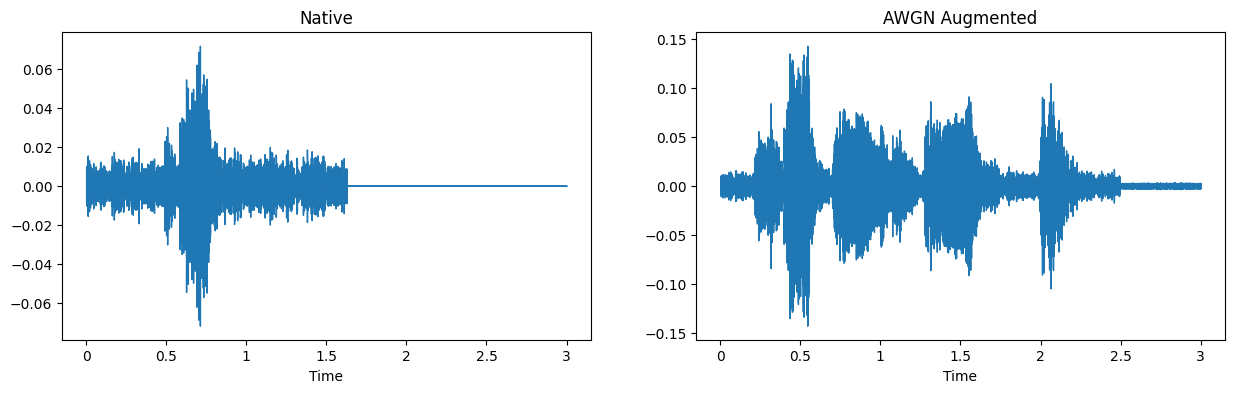

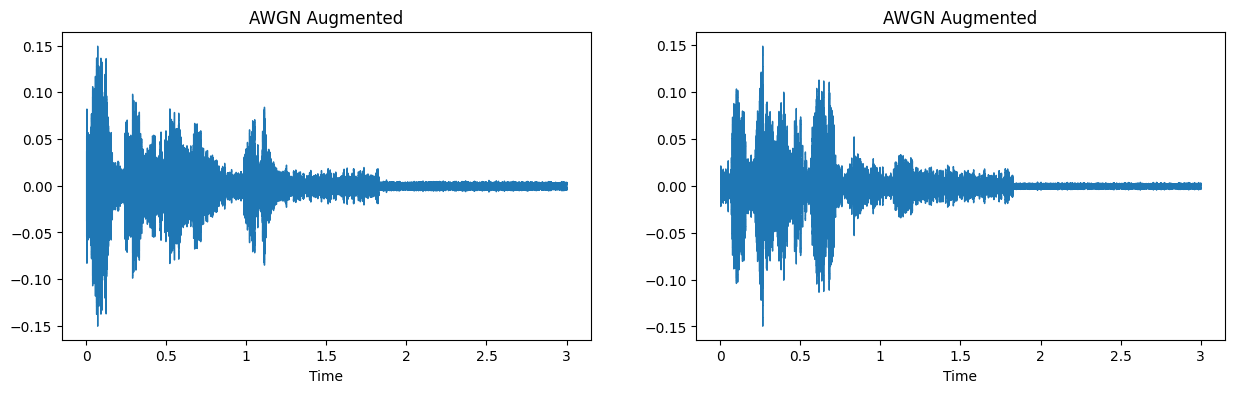

In [ ]:
# pick a random waveform, but same one from native and augmented set for easier comparison
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(waveforms[20], sr=sample_rate)
plt.title('Native')

plt.subplot(1, 2, 2)
# augmented waveforms are 2D len 1440 list with 2 waveforms in each position
librosa.display.waveshow(augmented_waveforms_temp[0][0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(augmented_waveforms_temp[2][0], sr=sample_rate)
plt.title('AWGN Augmented')

plt.subplot(1, 2, 2)
librosa.display.waveshow(augmented_waveforms_temp[7][0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

In [ ]:
print(len(features_train))
print(features_train[0].shape)



4788
(40, 282)


In [ ]:
# need to make dummy input channel for CNN input feature tensor
X_train = np.expand_dims(features_train,1)
X_valid = np.expand_dims(features_valid, 1)
X_test = np.expand_dims(features_test,1)

# convert emotion labels from list back to numpy arrays for PyTorch to work with
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# confiorm that we have tensor-ready 4D data array
# should print (batch, channel, width, height) == (4320, 1, 128, 282) when multiples==2
print(f'Shape of 4D feature array for input tensor: {X_train.shape} train, {X_valid.shape} validation, {X_test.shape} test')
print(f'Shape of emotion labels: {y_train.shape} train, {y_valid.shape} validation, {y_test.shape} test')

Shape of 4D feature array for input tensor: (4788, 1, 40, 282) train, (597, 1, 40, 282) validation, (615, 1, 40, 282) test
Shape of emotion labels: (4788,) train, (597,) validation, (615,) test


In [ ]:
del features_train, features_valid, features_test, waveforms, augmented_waveforms_temp

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#### Scale the training data ####
# store shape so we can transform it back
N,C,H,W = X_train.shape
# Reshape to 1D because StandardScaler operates on a 1D array
# tell numpy to infer shape of 1D array with '-1' argument
X_train = np.reshape(X_train, (N,-1))
X_train = scaler.fit_transform(X_train)
# Transform back to NxCxHxW 4D tensor format
X_train = np.reshape(X_train, (N,C,H,W))

##### Scale the validation set ####
N,C,H,W = X_valid.shape
X_valid = np.reshape(X_valid, (N,-1))
X_valid = scaler.transform(X_valid)
X_valid = np.reshape(X_valid, (N,C,H,W))

#### Scale the test set ####
N,C,H,W = X_test.shape
X_test = np.reshape(X_test, (N,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (N,C,H,W))

# check shape of each set again
print(f'X_train scaled:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid scaled:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test scaled:{X_test.shape}, y_test:{y_test.shape}')

X_train scaled:(4788, 1, 40, 282), y_train:(4788,)
X_valid scaled:(597, 1, 40, 282), y_valid:(597,)
X_test scaled:(615, 1, 40, 282), y_test:(615,)


In [ ]:
###### SAVE #########
# choose save file name
filename = 'CREMA-D features+labels(4000-6000).npy'
path = '/content/gdrive/My Drive/thesis/Thesis/Pre Data/'
fullPath = path+filename
# open file in write mode and write data
with open(fullPath, 'wb') as f:
    np.save(f, X_train)
    np.save(f, X_valid)
    np.save(f, X_test)
    np.save(f, y_train)
    np.save(f, y_valid)
    np.save(f, y_test)

print(f'Features and labels saved to {fullPath}')

Features and labels saved to /content/gdrive/My Drive/thesis/Thesis/Pre Data/CREMA-D features+labels(4000-6000).npy
